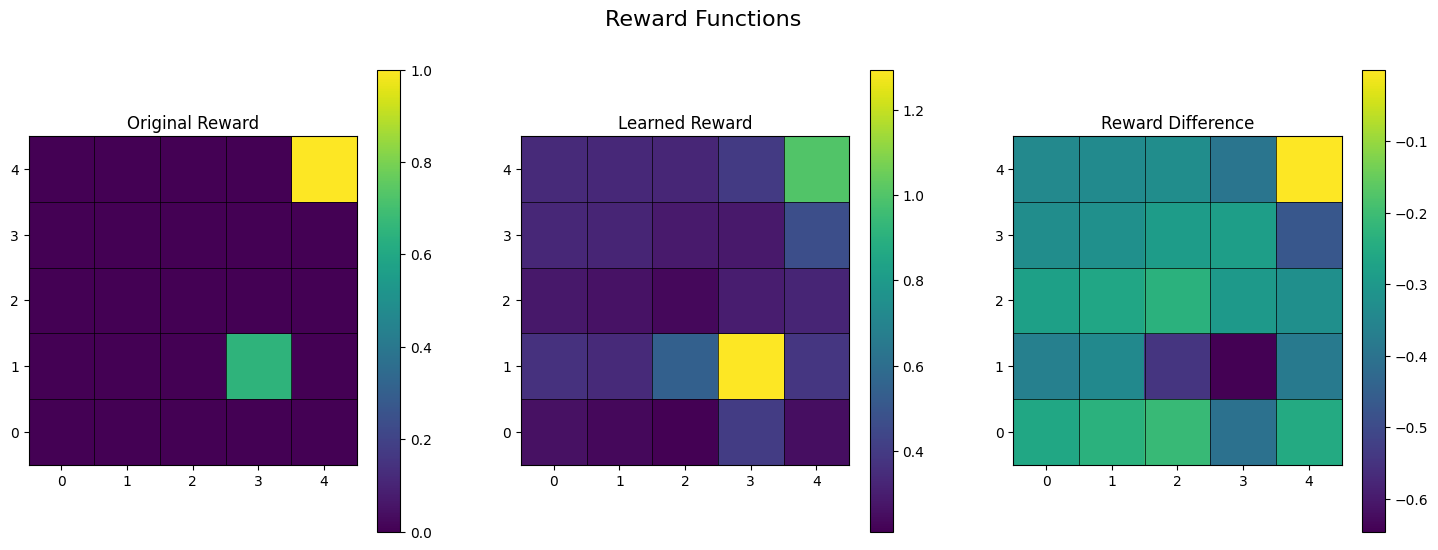

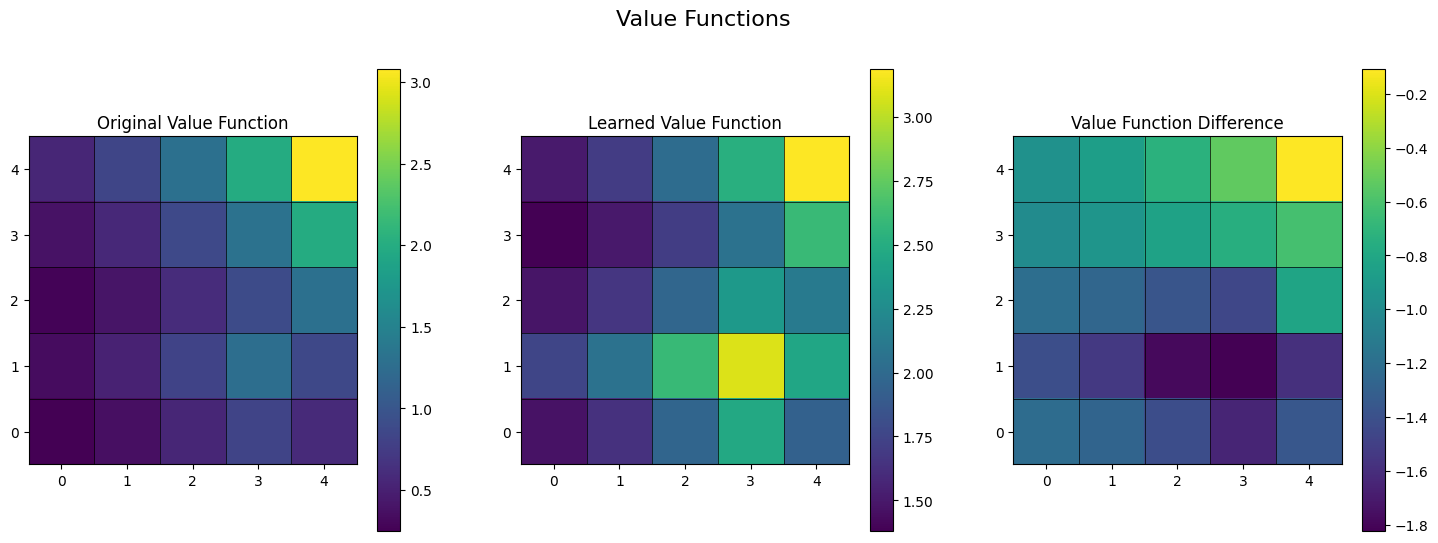

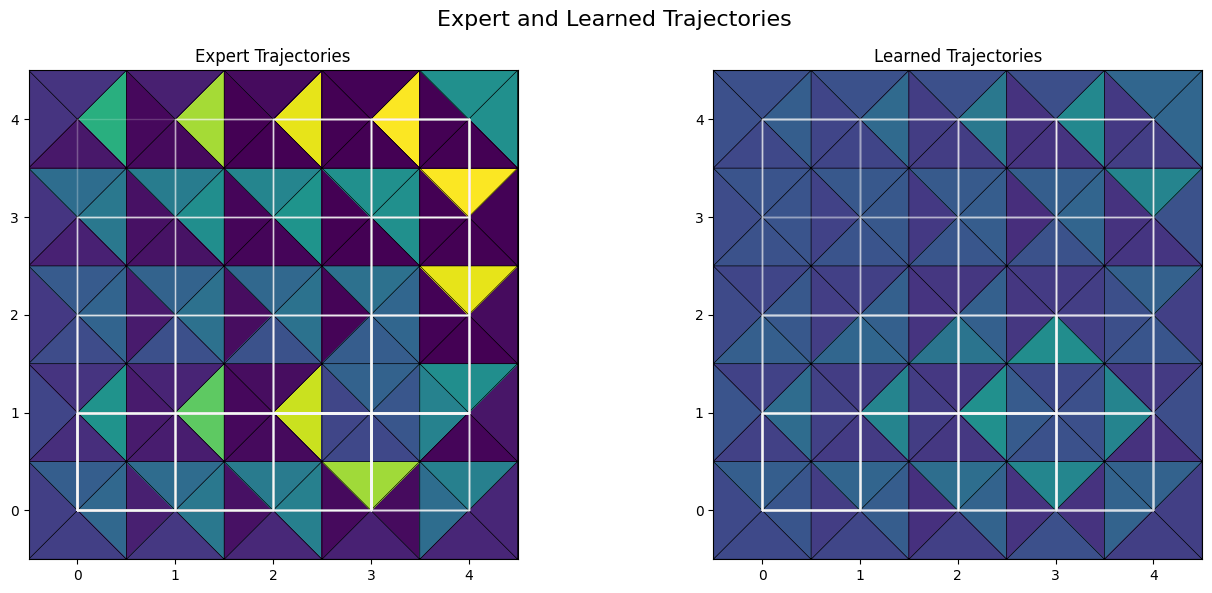


Original Reward Function:
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.65 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.  ]]

Learned Reward Function:
[[0.26 0.23 0.21 0.41 0.25]
 [0.36 0.34 0.55 1.3  0.38]
 [0.28 0.26 0.23 0.3  0.32]
 [0.33 0.32 0.29 0.28 0.47]
 [0.34 0.34 0.33 0.39 1.  ]]

Difference in Reward Function:
[[-0.26 -0.23 -0.21 -0.41 -0.25]
 [-0.36 -0.34 -0.55 -0.65 -0.38]
 [-0.28 -0.26 -0.23 -0.3  -0.32]
 [-0.33 -0.32 -0.29 -0.28 -0.47]
 [-0.34 -0.34 -0.33 -0.39 -0.  ]]

Original Value Function:
[[0.25 0.37 0.55 0.82 0.58]
 [0.34 0.52 0.81 1.27 0.86]
 [0.28 0.41 0.6  0.89 1.29]
 [0.38 0.57 0.87 1.32 1.99]
 [0.55 0.84 1.29 1.99 3.08]]

Learned Value Function:
[[1.46 1.64 1.97 2.47 1.94]
 [1.75 2.06 2.6  3.09 2.45]
 [1.48 1.66 1.98 2.35 2.11]
 [1.38 1.5  1.71 2.06 2.6 ]
 [1.51 1.7  2.02 2.52 3.19]]

Difference in Value Function:
[[-1.22 -1.27 -1.42 -1.65 -1.36]
 [-1.41 -1.54 -1.78 -1.83 -1.59]
 [-1.2  -1.26 -1.37 -1.46 -0.82]
 [-1

In [15]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.tri as tri

class GridWorld:
    def __init__(self, size):
        self.size = size
        self.actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        self.n_states = size**2
        self.n_actions = len(self.actions)
        self.p_transition = self._transition_prob_table()
    def state_index_to_point(self, state):
        return state % self.size, state // self.size
    def state_point_to_index(self, state):
        return state[1] * self.size + state[0]
    def state_point_to_index_clipped(self, state):
        s = (max(0, min(self.size - 1, state[0])), max(0, min(self.size - 1, state[1])))
        return self.state_point_to_index(s)
    def state_index_transition(self, s, a):
        s = self.state_index_to_point(s)
        s = s[0] + self.actions[a][0], s[1] + self.actions[a][1]
        return self.state_point_to_index_clipped(s)
    def _transition_prob_table(self):
        table = np.zeros((self.n_states, self.n_states, self.n_actions))
        s1, s2, a = range(self.n_states), range(self.n_states), range(self.n_actions)
        for s_from, s_to, a in product(s1, s2, a):
            table[s_from, s_to, a] = self._transition_prob(s_from, s_to, a)
        return table
    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]
        if fx + ax == tx and fy + ay == ty:
            return 1.0
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                return 1.0
        return 0.0
    def __repr__(self):
        return "GridWorld(size={})".format(self.size)

class IcyGridWorld(GridWorld):
    def __init__(self, size, p_slip=0.2):
        self.p_slip = p_slip
        super().__init__(size)
    def _transition_prob(self, s_from, s_to, a):
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]
        if fx + ax == tx and fy + ay == ty:
            return 1.0 - self.p_slip + self.p_slip / self.n_actions
        if abs(fx - tx) + abs(fy - ty) == 1:
            return self.p_slip / self.n_actions
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                    return 1.0 - self.p_slip + 2.0 * self.p_slip / self.n_actions
                return 1.0 - self.p_slip + self.p_slip / self.n_actions
            if not 0 < fx < self.size - 1 and not 0 < fy < self.size - 1:
                return 2.0 * self.p_slip / self.n_actions
            if not 0 < fx < self.size - 1 or not 0 < fy < self.size - 1:
                return self.p_slip / self.n_actions
            return 0.0
        return 0.0
    def __repr__(self):
        return "IcyGridWorld(size={}, p_slip={})".format(self.size, self.p_slip)

def state_features(world):
    return np.identity(world.n_states)

def coordinate_features(world):
    features = np.zeros((world.n_states, world.size))
    for s in range(world.n_states):
        x, y = world.state_index_to_point(s)
        features[s, x] += 1
        features[s, y] += 1
    return features

def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape
    fe = np.zeros(n_features)
    for t in trajectories:
        for s in t.states():
            fe += features[s, :]
    return fe / len(trajectories)

def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)
    for t in trajectories:
        p[t.transitions()[0][0]] += 1.0
    return p / len(trajectories)

def expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    p_transition = np.copy(p_transition)
    p_transition[terminal, :, :] = 0.0
    p_transition = [np.array(p_transition[:, :, a]) for a in range(n_actions)]
    d = np.zeros(n_states)
    delta = np.inf
    while delta > eps:
        d_ = [p_transition[a].T.dot(p_action[:, a] * d) for a in range(n_actions)]
        d_ = p_initial + np.array(d_).sum(axis=0)
        delta, d = np.max(np.abs(d_ - d)), d_
    return d

def local_action_probabilities(p_transition, terminal, reward):
    n_states, _, n_actions = p_transition.shape
    er = np.exp(reward)
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]
    zs = np.zeros(n_states)
    zs[terminal] = 1.0
    for _ in range(2 * n_states):
        za = np.array([er * p[a].dot(zs) for a in range(n_actions)]).T
        zs = za.sum(axis=1)
    return za / zs[:, None]

def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    p_action = local_action_probabilities(p_transition, terminal, reward)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps)

def irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4, eps_esvf=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)
    theta = init(n_features)
    delta = np.inf
    optim.reset(theta)
    while delta > eps:
        theta_old = theta.copy()
        reward = features.dot(theta)
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward, eps_esvf)
        grad = e_features - features.T.dot(e_svf)
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
    return features.dot(theta)

def softmax(x1, x2):
    x_max = np.maximum(x1, x2)
    x_min = np.minimum(x1, x2)
    return x_max + np.log(1.0 + np.exp(x_min - x_max))

def local_causal_action_probabilities(p_transition, terminal, reward, discount, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    if len(terminal) == n_states:
        reward_terminal = np.array(terminal, dtype=float)
    else:
        reward_terminal = -np.inf * np.ones(n_states)
        reward_terminal[terminal] = 0.0
    p = [np.array(p_transition[:, :, a]) for a in range(n_actions)]
    v = -1e200 * np.ones(n_states)
    delta = np.inf
    while delta > eps:
        v_old = v
        q = np.array([reward + discount * p[a].dot(v_old) for a in range(n_actions)]).T
        v = reward_terminal
        for a in range(n_actions):
            v = softmax(v, q[:, a])
        v = np.array(v, dtype=float)
        delta = np.max(np.abs(v - v_old))
    return np.exp(q - v[:, None])

def compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                eps_lap=1e-5, eps_svf=1e-5):
    p_action = local_causal_action_probabilities(p_transition, terminal, reward, discount, eps_lap)
    return expected_svf_from_policy(p_transition, p_initial, terminal, p_action, eps_svf)

def irl_causal(p_transition, features, terminal, trajectories, optim, init, discount,
               eps=1e-4, eps_svf=1e-5, eps_lap=1e-5):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape
    e_features = feature_expectation_from_trajectories(features, trajectories)
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)
    theta = init(n_features)
    delta = np.inf
    optim.reset(theta)
    while delta > eps:
        theta_old = theta.copy()
        reward = features.dot(theta)
        e_svf = compute_expected_causal_svf(p_transition, p_initial, terminal, reward, discount,
                                            eps_lap, eps_svf)
        grad = e_features - features.T.dot(e_svf)
        optim.step(grad)
        delta = np.max(np.abs(theta_old - theta))
    return features.dot(theta)

class Optimizer:
    def __init__(self):
        self.parameters = None
    def reset(self, parameters):
        self.parameters = parameters
    def step(self, grad, *args, **kwargs):
        raise NotImplementedError
    def normalize_grad(self, ord=None):
        return NormalizeGrad(self, ord)

class Sga(Optimizer):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.k = 0
    def reset(self, parameters):
        super().reset(parameters)
        self.k = 0
    def step(self, grad, *args, **kwargs):
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1
        self.parameters += lr * grad

class ExpSga(Optimizer):
    def __init__(self, lr, normalize=False):
        super().__init__()
        self.lr = lr
        self.normalize = normalize
        self.k = 0
    def reset(self, parameters):
        super().reset(parameters)
        self.k = 0
    def step(self, grad, *args, **kwargs):
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1
        self.parameters *= np.exp(lr * grad)
        if self.normalize:
            self.parameters /= self.parameters.sum()

class NormalizeGrad(Optimizer):
    def __init__(self, opt, ord=None):
        super().__init__()
        self.opt = opt
        self.ord = ord
    def reset(self, parameters):
        super().reset(parameters)
        self.opt.reset(parameters)
    def step(self, grad, *args, **kwargs):
        return self.opt.step(grad / np.linalg.norm(grad, self.ord), *args, **kwargs)

def linear_decay(lr0=0.2, decay_rate=1.0, decay_steps=1):
    def _lr(k):
        return lr0 / (1.0 + decay_rate * np.floor(k / decay_steps))
    return _lr

def power_decay(lr0=0.2, decay_rate=1.0, decay_steps=1, power=2):
    def _lr(k):
        return lr0 / (decay_rate * np.floor(k / decay_steps) + 1.0)**power
    return _lr

def exponential_decay(lr0=0.2, decay_rate=0.5, decay_steps=1):
    def _lr(k):
        return lr0 * np.exp(-decay_rate * np.floor(k / decay_steps))
    return _lr

class Initializer:
    def __init__(self):
        pass
    def initialize(self, shape):
        raise NotImplementedError
    def __call__(self, shape):
        return self.initialize(shape)

class Uniform(Initializer):
    def __init__(self, low=0.0, high=1.0):
        super().__init__()
        self.low = low
        self.high = high
    def initialize(self, shape):
        return np.random.uniform(size=shape, low=self.low, high=self.high)

class Constant(Initializer):
    def __init__(self, value=1.0):
        super().__init__()
        self.value = value
    def initialize(self, shape):
        if callable(self.value):
            return np.ones(shape) * self.value(shape)
        else:
            return np.ones(shape) * self.value

def plot_transition_probabilities(ax, world, border=None, **kwargs):
    xy = [(x - 0.5, y - 0.5) for y, x in product(range(world.size + 1), range(world.size + 1))]
    xy += [(x, y) for y, x in product(range(world.size), range(world.size))]
    t, v = [], []
    for sy, sx in product(range(world.size), range(world.size)):
        state = world.state_point_to_index((sx, sy))
        state_r = world.state_point_to_index_clipped((sx + 1, sy))
        state_l = world.state_point_to_index_clipped((sx - 1, sy))
        state_t = world.state_point_to_index_clipped((sx, sy + 1))
        state_b = world.state_point_to_index_clipped((sx, sy - 1))
        bl, br = sy * (world.size + 1) + sx, sy * (world.size + 1) + sx + 1
        tl, tr = (sy + 1) * (world.size + 1) + sx, (sy + 1) * (world.size + 1) + sx + 1
        cc = (world.size + 1)**2 + sy * world.size + sx
        t += [(tr, cc, br)]
        t += [(tl, bl, cc)]
        t += [(tl, cc, tr)]
        t += [(bl, br, cc)]
        v += [world.p_transition[state, state_r, 0]]
        v += [world.p_transition[state, state_l, 1]]
        v += [world.p_transition[state, state_t, 2]]
        v += [world.p_transition[state, state_b, 3]]
    x, y = zip(*xy)
    x, y = np.array(x), np.array(y)
    t, v = np.array(t), np.array(v)
    ax.set_aspect('equal')
    ax.set_xticks(range(world.size))
    ax.set_yticks(range(world.size))
    ax.set_xlim(-0.5, world.size - 0.5)
    ax.set_ylim(-0.5, world.size - 0.5)
    p = ax.tripcolor(x, y, t, facecolors=v, vmin=0.0, vmax=1.0, **kwargs)
    if border is not None:
        ax.triplot(x, y, t, **border)
    return p

def plot_state_values(ax, world, values, border, **kwargs):
    p = ax.imshow(np.reshape(values, (world.size, world.size)), origin='lower', **kwargs)
    if border is not None:
        for i in range(0, world.size + 1):
            ax.plot([i - 0.5, i - 0.5], [-0.5, world.size - 0.5], **border, label=None)
            ax.plot([-0.5, world.size - 0.5], [i - 0.5, i - 0.5], **border, label=None)
    return p

def plot_deterministic_policy(ax, world, policy, **kwargs):
    arrow_direction = [(0.33, 0), (-0.33, 0), (0, 0.33), (0, -0.33)]
    for state in range(world.n_states):
        cx, cy = world.state_index_to_point(state)
        dx, dy = arrow_direction[policy[state]]
        ax.arrow(cx - 0.5 * dx, cy - 0.5 * dy, dx, dy, head_width=0.1, **kwargs)

def plot_stochastic_policy(ax, world, policy, border=None, **kwargs):
    xy = [(x - 0.5, y - 0.5) for y, x in product(range(world.size + 1), range(world.size + 1))]
    xy += [(x, y) for y, x in product(range(world.size), range(world.size))]
    t, v = [], []
    for sy, sx in product(range(world.size), range(world.size)):
        state = world.state_point_to_index((sx, sy))
        bl, br = sy * (world.size + 1) + sx, sy * (world.size + 1) + sx + 1
        tl, tr = (sy + 1) * (world.size + 1) + sx, (sy + 1) * (world.size + 1) + sx + 1
        cc = (world.size + 1)**2 + sy * world.size + sx
        t += [(tr, cc, br)]
        t += [(tl, bl, cc)]
        t += [(tl, cc, tr)]
        t += [(bl, br, cc)]
        v += [policy[state, 0]]
        v += [policy[state, 1]]
        v += [policy[state, 2]]
        v += [policy[state, 3]]
    x, y = zip(*xy)
    x, y = np.array(x), np.array(y)
    t, v = np.array(t), np.array(v)
    ax.set_aspect('equal')
    ax.set_xticks(range(world.size))
    ax.set_yticks(range(world.size))
    ax.set_xlim(-0.5, world.size - 0.5)
    ax.set_ylim(-0.5, world.size - 0.5)
    p = ax.tripcolor(x, y, t, facecolors=v, vmin=0.0, vmax=1.0, **kwargs)
    if border is not None:
        ax.triplot(x, y, t, **border)
    return p

def plot_trajectory(ax, world, trajectory, **kwargs):
    xy = [world.state_index_to_point(s) for s in trajectory.states()]
    x, y = zip(*xy)
    return ax.plot(x, y, **kwargs)

def value_iteration(p, reward, discount, eps=1e-3):
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)
    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]
    delta = np.inf
    while delta > eps:
        v_old = v
        q = discount * np.array([p[a] @ v for a in range(n_actions)])
        v = reward + np.max(q, axis=0)[0]
        delta = np.max(np.abs(v_old - v))
    return v

def stochastic_value_iteration(p, reward, discount, eps=1e-3):
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)
    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]
    delta = np.inf
    while delta > eps:
        v_old = v
        q = discount * np.array([p[a] @ v for a in range(n_actions)])
        v = reward + np.average(q, axis=0)[0]
        delta = np.max(np.abs(v_old - v))
    return v

def optimal_policy_from_value(world, value):
    policy = np.array([
        np.argmax([value[world.state_index_transition(s, a)] for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])
    return policy

def optimal_policy(world, reward, discount, eps=1e-3):
    value = value_iteration(world.p_transition, reward, discount, eps)
    return optimal_policy_from_value(world, value)

def stochastic_policy_from_value(world, value, w=lambda x: x):
    value = np.exp(value)
    q = np.array([
        np.array([w(value[world.state_index_transition(s, a)]) for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])
    return q / np.sum(q, axis=1)[:, None]

from itertools import chain

class Trajectory:
    def __init__(self, transitions):
        self._t = transitions
    def transitions(self):
        return self._t
    def states(self):
        return map(lambda x: x[0], chain(self._t, [(self._t[-1][2], 0, 0)]))
    def __repr__(self):
        return "Trajectory({})".format(repr(self._t))
    def __str__(self):
        return "{}".format(self._t)

def generate_trajectory(world, policy, start, final):
    state = start
    trajectory = []
    while state not in final:
        action = policy(state)
        next_s = range(world.n_states)
        next_p = world.p_transition[state, :, action]
        next_state = np.random.choice(next_s, p=next_p)
        trajectory += [(state, action, next_state)]
        state = next_state
    return Trajectory(trajectory)

def generate_trajectories(n, world, policy, start, final):
    start_states = np.atleast_1d(start)
    def _generate_one():
        if len(start_states) == world.n_states:
            s = np.random.choice(range(world.n_states), p=start_states)
        else:
            s = np.random.choice(start_states)
        return generate_trajectory(world, policy, s, final)
    return (_generate_one() for _ in range(n))

def policy_adapter(policy):
    return lambda state: policy[state]

def stochastic_policy_adapter(policy):
    return lambda state: np.random.choice([*range(policy.shape[1])], p=policy[state, :])

def setup_mdp():
    world = IcyGridWorld(size=5, p_slip=0.2)
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65
    terminal = [24]
    return world, reward, terminal

def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200
    discount = 0.7
    weighting = lambda x: x**5
    initial = np.zeros(world.n_states)
    initial[0] = 1.0
    value = value_iteration(world.p_transition, reward, discount)
    policy = stochastic_policy_from_value(world, value, w=weighting)
    policy_exec = stochastic_policy_adapter(policy)
    tjs = list(generate_trajectories(n_trajectories, world, policy_exec, initial, terminal))
    return tjs, policy

def maxent(world, terminal, trajectories):
    features = state_features(world)
    init = Constant(1.0)
    optim = ExpSga(lr=linear_decay(lr0=0.2))
    reward = irl(world.p_transition, features, terminal, trajectories, optim, init)
    return reward

def maxent_causal(world, terminal, trajectories, discount=0.7):
    features = state_features(world)
    init = Constant(1.0)
    optim = ExpSga(lr=linear_decay(lr0=0.2))
    reward = irl_causal(world.p_transition, features, terminal, trajectories, optim, init, discount)
    return reward

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# (All the classes and functions remain the same as in your original code)
# Please ensure all previous definitions are included here

def main():
    style = {'border': {'color': 'black', 'linewidth': 0.5}}

    # Set up the MDP
    world, reward, terminal = setup_mdp()

    # Generate expert trajectories
    trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)

    # Learn reward function using MaxEnt
    reward_maxent = maxent(world, terminal, trajectories)

    # Compute the difference between original and learned reward
    reward_diff = reward - reward_maxent

    # Compute the value function for the original reward
    discount = 0.7
    value_original = value_iteration(world.p_transition, reward, discount)

    # Compute the value function for the learned reward
    value_maxent = value_iteration(world.p_transition, reward_maxent, discount)

    # Compute the difference between the value functions
    value_diff = value_original - value_maxent

    # Plot the original and learned reward functions and their difference
    fig1, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig1.suptitle('Reward Functions', fontsize=16)

    p = plot_state_values(axes1[0], world, reward, **style)
    axes1[0].set_title('Original Reward')
    fig1.colorbar(p, ax=axes1[0])

    p = plot_state_values(axes1[1], world, reward_maxent, **style)
    axes1[1].set_title('Learned Reward')
    fig1.colorbar(p, ax=axes1[1])

    p = plot_state_values(axes1[2], world, reward_diff, **style)
    axes1[2].set_title('Reward Difference')
    fig1.colorbar(p, ax=axes1[2])

    # Plot the value functions
    fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig2.suptitle('Value Functions', fontsize=16)

    p = plot_state_values(axes2[0], world, value_original, **style)
    axes2[0].set_title('Original Value Function')
    fig2.colorbar(p, ax=axes2[0])

    p = plot_state_values(axes2[1], world, value_maxent, **style)
    axes2[1].set_title('Learned Value Function')
    fig2.colorbar(p, ax=axes2[1])

    p = plot_state_values(axes2[2], world, value_diff, **style)
    axes2[2].set_title('Value Function Difference')
    fig2.colorbar(p, ax=axes2[2])

    # Generate trajectories from the learned policy
    policy_learned = stochastic_policy_from_value(world, value_maxent)
    policy_learned_exec = stochastic_policy_adapter(policy_learned)
    n_trajectories = 50
    initial = np.zeros(world.n_states)
    initial[0] = 1.0
    learned_trajectories = list(generate_trajectories(n_trajectories, world, policy_learned_exec, initial, terminal))

    # Plot expert and learned trajectories
    fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig3.suptitle('Expert and Learned Trajectories', fontsize=16)

    axes3[0].set_title('Expert Trajectories')
    plot_stochastic_policy(axes3[0], world, expert_policy, **style)
    for t in trajectories:
        plot_trajectory(axes3[0], world, t, lw=1, color='white', alpha=0.1)

    axes3[1].set_title('Learned Trajectories')
    plot_stochastic_policy(axes3[1], world, policy_learned, **style)
    for t in learned_trajectories:
        plot_trajectory(axes3[1], world, t, lw=1, color='white', alpha=0.1)

    plt.tight_layout()
    plt.show()

    # Print the reward functions and value functions in tabular form
    np.set_printoptions(precision=2, suppress=True)

    print("\nOriginal Reward Function:")
    print(np.reshape(reward, (world.size, world.size)))

    print("\nLearned Reward Function:")
    print(np.reshape(reward_maxent, (world.size, world.size)))

    print("\nDifference in Reward Function:")
    print(np.reshape(reward_diff, (world.size, world.size)))

    print("\nOriginal Value Function:")
    print(np.reshape(value_original, (world.size, world.size)))

    print("\nLearned Value Function:")
    print(np.reshape(value_maxent, (world.size, world.size)))

    print("\nDifference in Value Function:")
    print(np.reshape(value_diff, (world.size, world.size)))

if __name__ == '__main__':
    main()
